# In which Elizabeth learns something about forecasting

Playing with Kaggle competition [on predicting future sales](https://www.kaggle.com/c/competitive-data-science-predict-future-sales).

## Predicting Sales

Goal: predict total sales for **every product** and **every store** in the test set for the next month. 
Evaluation metric: [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation)

In [6]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

In [7]:
train = pd.read_csv('sales_train_v2.csv')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [8]:
print(len(train.item_id.unique()), 'unique items were purchased at', len(train.shop_id.unique()), 'unique shops over', \
      len(train.date_block_num.unique()), 'months.')

dfg = train.groupby(['shop_id', 'item_id'])

21807 unique items were purchased at 60 unique shops over 34 months.


In [9]:
def sum_items_sold_each_month(shop_id, item_id):
    try:
        df = dfg.get_group((shop_id, item_id))
    except KeyError:
        return [0]*34
    
    dfs = df.groupby("date_block_num").sum()
    
    if len(dfs.item_cnt_day) < 34:
        y = []
        for x in range(34):
            try: 
                y.append(dfs.loc[x].item_cnt_day)
            except KeyError:
                y.append(0)
        return y
    return dfs.item_cnt_day.values


def plot_items_sold_each_month(shop, item):
    y = sum_items_sold_each_month(shop, item)
    fig = plt.figure()
    plt.plot(range(34), y, 'o-')
    plt.xlabel('month')
    plt.ylabel('total items sold')
    plt.title(' '.join(('Item', str(item), 'sold at Shop', str(shop), 'over time')))
    return fig, plt.gca()


def plot_prediction(shop, item, predicted_val, label='predicted'):
    fig, ax = plot_items_sold_each_month(shop, item)
    ax.plot(34, predicted_val, 'or', label=label)
    ax.set_xlim(0, 35)
    ax.legend()
    

def prediction_equals_last_month_average(shop, item):
    """ Submission #1, RMSE = 1.21476 """
    try:
        df = dfg.get_group((shop, item))
    except KeyError:
        return 0
    
    df = df[df.date_block_num == 33]
    ave = df.item_cnt_day.mean()
    if np.isnan(ave):
        return 0
    return ave
    
    
def prediction_equals_last_month_total(shop, item):
    """ Submission #2, RMSE = 8.53027 """
    return sum_items_sold_each_month(shop, item)[-1]


def prediction_equals_nmonth_average(shop, item, n_months):
    """ Submission #3, n_months=5, RMSE = 2.86279 """
    return np.mean(sum_items_sold_each_month(shop, item)[-n_months:])

595.4

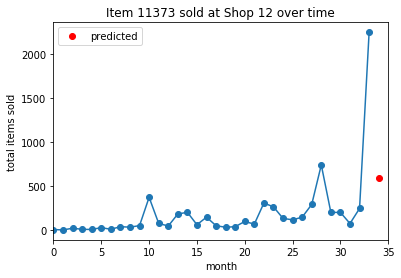

In [10]:
shop = 12

item = 30
item = 0
item = 11373 

pred = prediction_equals_nmonth_average(shop, item, 5)
plot_prediction(shop, item, pred)
pred

In [11]:
test = pd.read_csv('test.csv')
len(test)

214200

In [12]:
# Keywords are broken for first two submissions.
def make_predictions(prediction_function, filename='submission.csv', n_months=5):
    shops = test.shop_id.values
    items = test.item_id.values
    IDs = test.ID.values
    output = 'ID,item_cnt_month'

    for shop, item, ID in zip(shops, items, IDs):
        line = ','.join((str(ID), str(prediction_function(shop=shop, item=item, n_months=n_months))))
        output = '\n'.join((output, line))
        
    with open(filename, "w") as f:
        f.write(output)

In [13]:
start = timer()
make_predictions(prediction_function=prediction_equals_nmonth_average, 
                 filename='submission03_rollingave_5months.csv', n_months=5)
end = timer()
print((start-end)/60, 'minutes')

-14.587603831424834 minutes
